# Imports

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CelebA

from helper_plot import plot_images, plot_generated_images
from helper_train import train_gan

# Config

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 256
NUM_EPOCHS = 20
LR_GENERATOR = 0.0002
LR_DISCRIMINATOR = 0.0002
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 64, 3

# Dataset

In [4]:
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160, 160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

celeba_dataset = CelebA('../Dataset', split='train', download= True, transform = data_transforms)
train_loader = DataLoader(celeba_dataset, batch_size = BATCH_SIZE, shuffle = True)
images, labels = next(iter(train_loader))
print(torch.min(images), torch.max(images))


Files already downloaded and verified
tensor(-1.) tensor(1.)


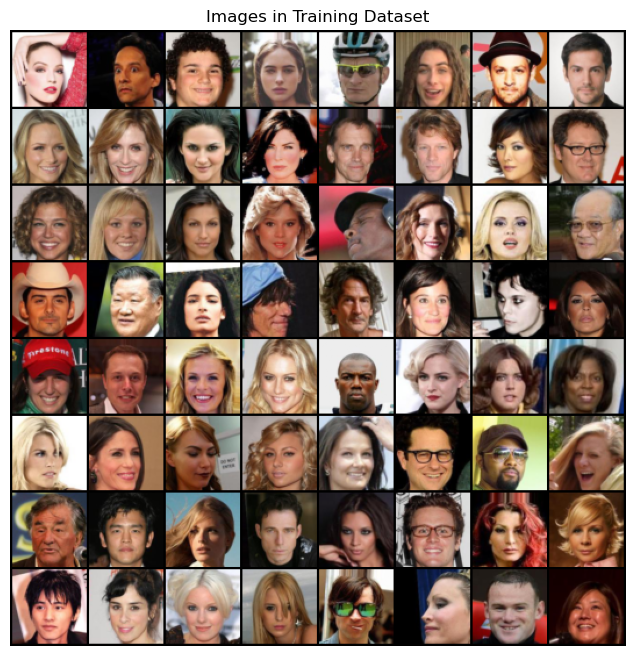

In [6]:
plot_images(train_loader)

# DCGAN

In [8]:
class DCGAN(nn.Module):
    def __init__(self, latent_dim = 100):
        super().__init__()

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1,bias=False),
            nn.Tanh()
        )


        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
        
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),        
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
    
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),        
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),        
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(),   
        )

    def generator_forward(self, z):
        img = self.generator(z)
        return img

    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits

In [9]:
model = DCGAN().to(DEVICE)
optimizer_generator = torch.optim.Adam(model.generator.parameters(), 
                                        lr = LR_GENERATOR,
                                        betas=(0.5, 0.999))

optimizer_discriminator = torch.optim.Adam(model.discriminator.parameters(),
                                         lr = LR_DISCRIMINATOR,
                                         betas=(0.5, 0.999))

# Training

In [10]:
log_dict = train_gan(model = model, 
                     train_loader = train_loader, 
                     optimizer_generator = optimizer_generator, 
                     optimizer_discriminator = optimizer_discriminator, 
                     num_epochs = NUM_EPOCHS, 
                     latent_dim = 100)

c:\ProgramData\miniconda3\envs\rsna\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/20]                     Loss D: 0.6798, loss G: 1.5531
Epoch [1/20]                     Loss D: 0.1036, loss G: 3.1498
Epoch [1/20]                     Loss D: 0.4571, loss G: 6.8124
Epoch [1/20]                     Loss D: 0.2731, loss G: 3.3602
Epoch [1/20]                     Loss D: 0.3370, loss G: 4.9114
Epoch [1/20]                     Loss D: 0.2551, loss G: 3.5631
Epoch [1/20]                     Loss D: 0.2245, loss G: 2.9350
Epoch [2/20]                     Loss D: 0.2746, loss G: 2.8778
Epoch [2/20]                     Loss D: 0.3242, loss G: 3.1005
Epoch [2/20]                     Loss D: 0.2730, loss G: 1.6529
Epoch [2/20]                     Loss D: 0.5213, loss G: 8.5436
Epoch [2/20]                     Loss D: 0.5716, loss G: 0.5623
Epoch [2/20]                     Loss D: 0.2619, loss G: 0.6293
Epoch [2/20]                     Loss D: 0.3801, loss G: 1.0977
Epoch [3/20]                     Loss D: 0.1272, loss G: 2.9693
Epoch [3/20]                     Loss D:

# Visualization

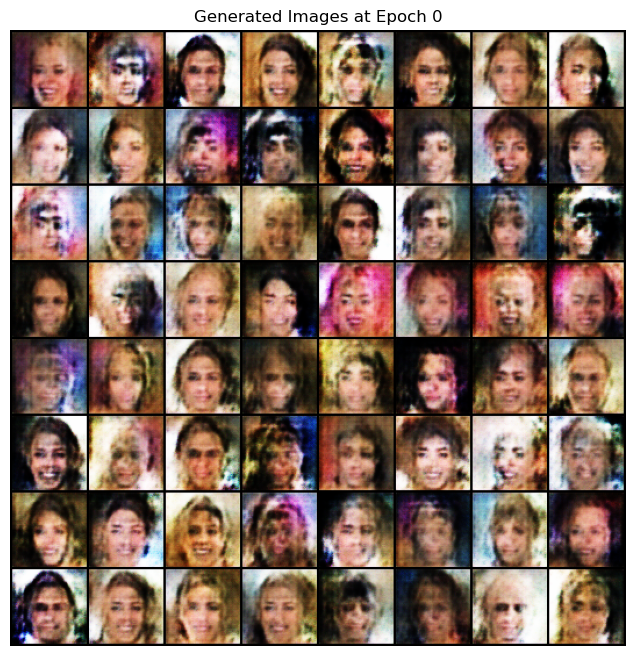

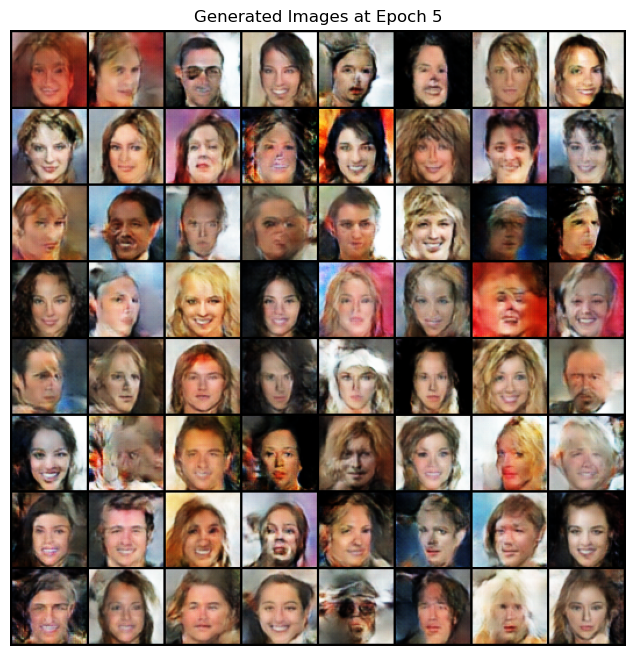

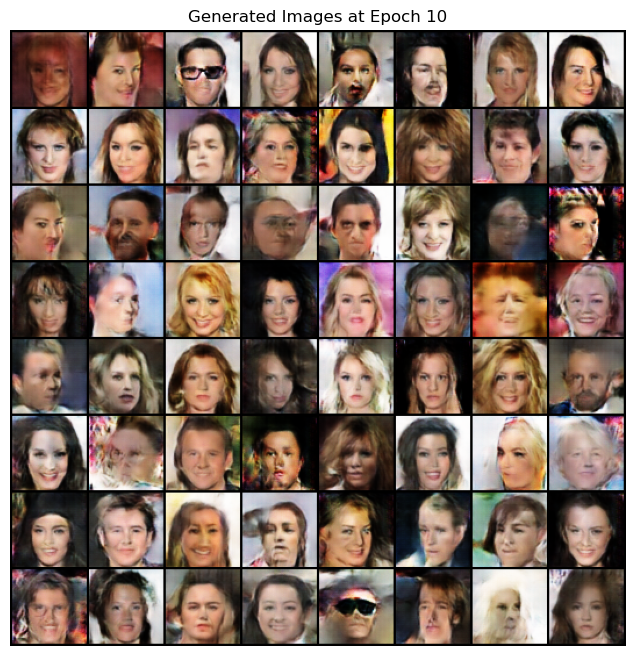

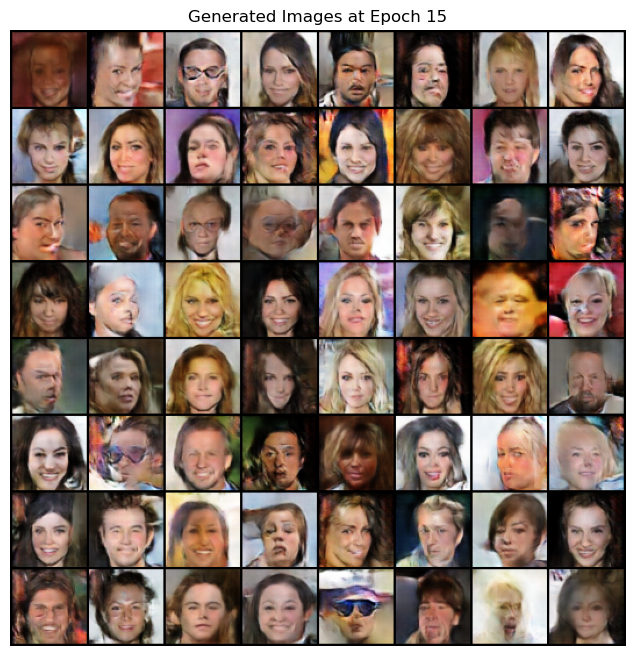

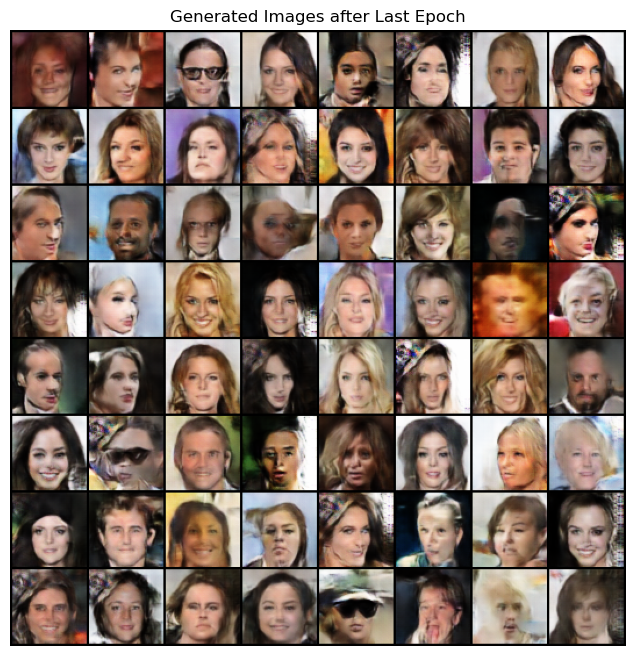

In [15]:
plot_generated_images(NUM_EPOCHS, log_dict)